# EWB paper figure 1: showing all the cases

We provide the exact code used to generate each figure in order to be completely reproducible and to encourage others to use EWB with their own models quickly. 
This is Figure 1, the initial figure that shows all of the cases, both globally and then zoomed in

In [1]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from pathlib import Path
from matplotlib.patches import Patch

import case_plotting

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [2]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()

# turn the dictionary into a list of case objects
ewb_cases = cases.load_individual_cases(case_dict)

# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(case_dict, defaults.get_brightband_evaluation_objects())

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [3]:
# useful for debugging
print(ewb_cases)


IndividualCaseCollection(cases=[IndividualCase(case_id_number=1, title='2021 Pacific Northwest', start_date=datetime.datetime(2021, 6, 20, 0, 0), end_date=datetime.datetime(2021, 7, 3, 0, 0), location=BoundingBoxRegion(latitude_min=33.25, latitude_max=68.0, longitude_min=215.25, longitude_max=256.0), event_type='heat_wave'), IndividualCase(case_id_number=2, title='2022 Upper Midwest', start_date=datetime.datetime(2022, 5, 7, 0, 0), end_date=datetime.datetime(2022, 5, 17, 0, 0), location=BoundingBoxRegion(latitude_min=19.5, latitude_max=48.25, longitude_min=252.0, longitude_max=276.75), event_type='heat_wave'), IndividualCase(case_id_number=3, title='2022 California', start_date=datetime.datetime(2022, 6, 7, 0, 0), end_date=datetime.datetime(2022, 6, 15, 0, 0), location=BoundingBoxRegion(latitude_min=23.75, latitude_max=44.5, longitude_min=235.75, longitude_max=266.25), event_type='heat_wave'), IndividualCase(case_id_number=4, title='2022 Texas', start_date=datetime.datetime(2022, 6, 30

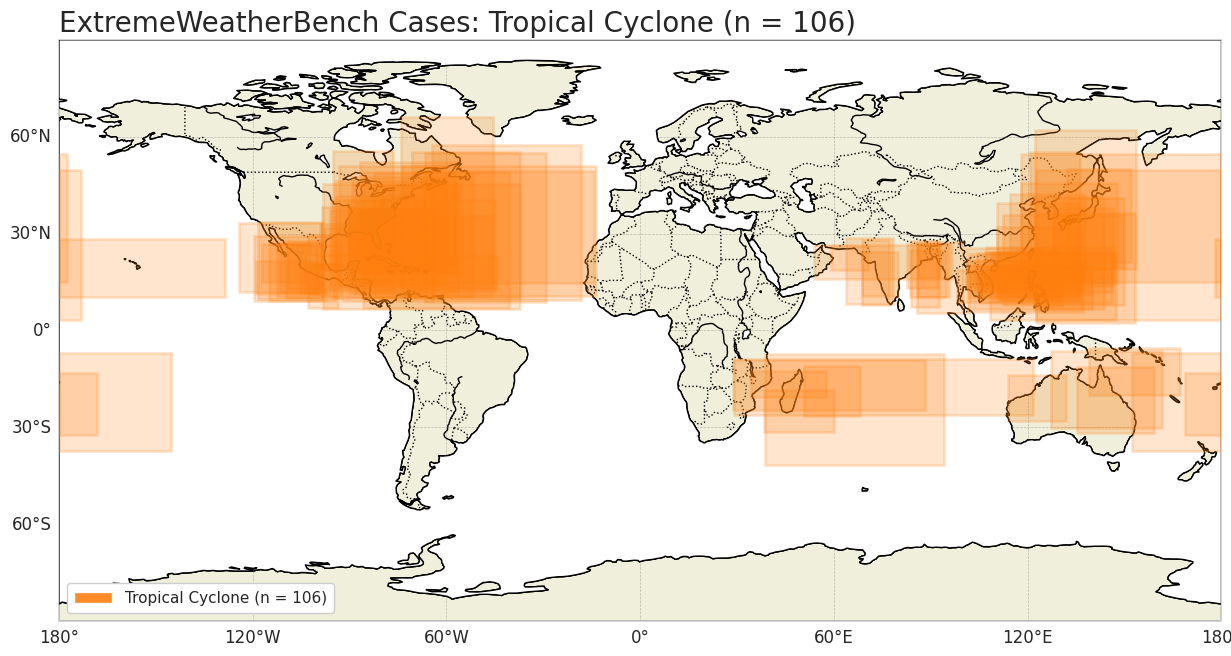

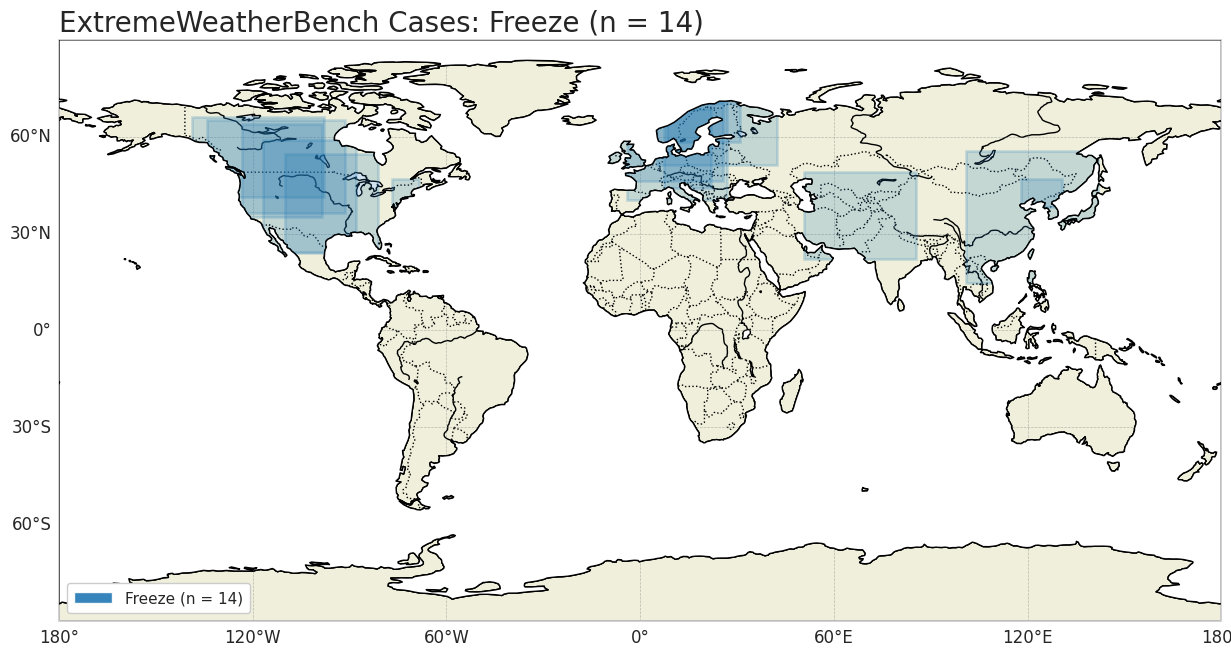

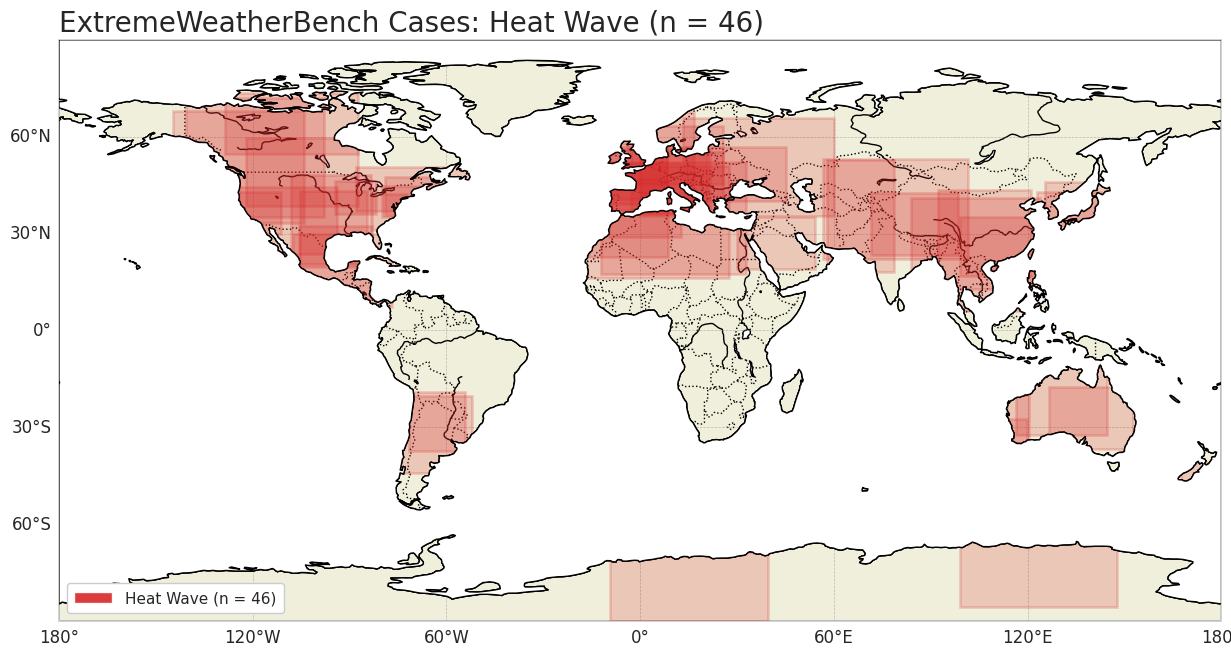

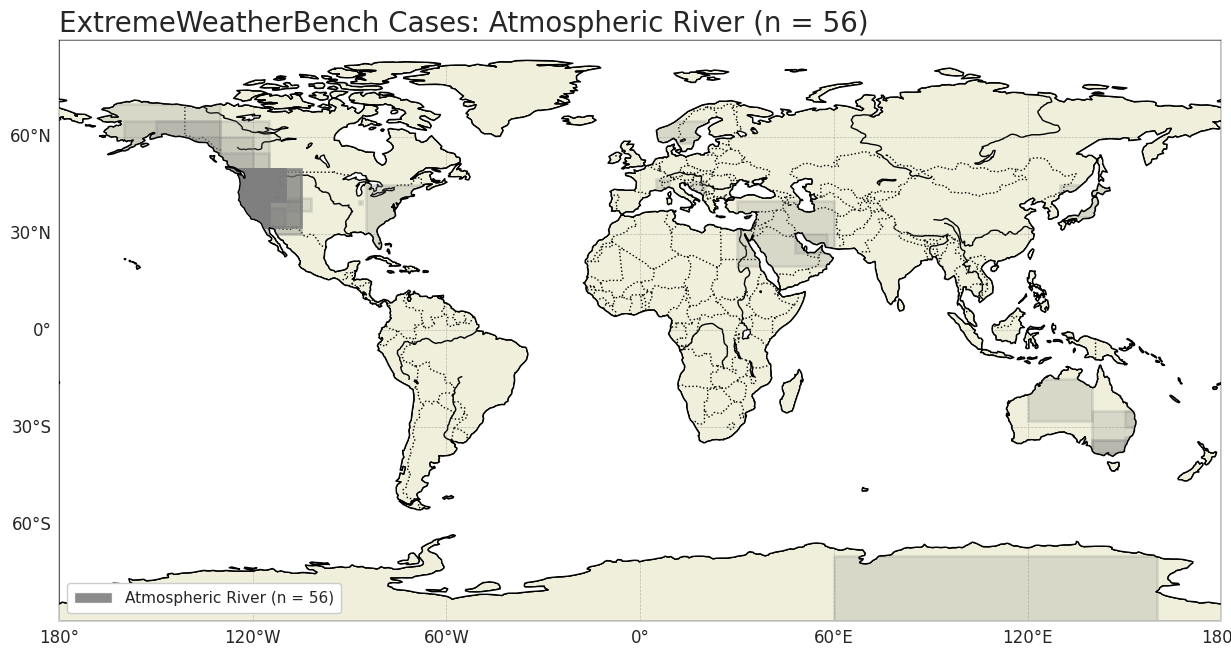

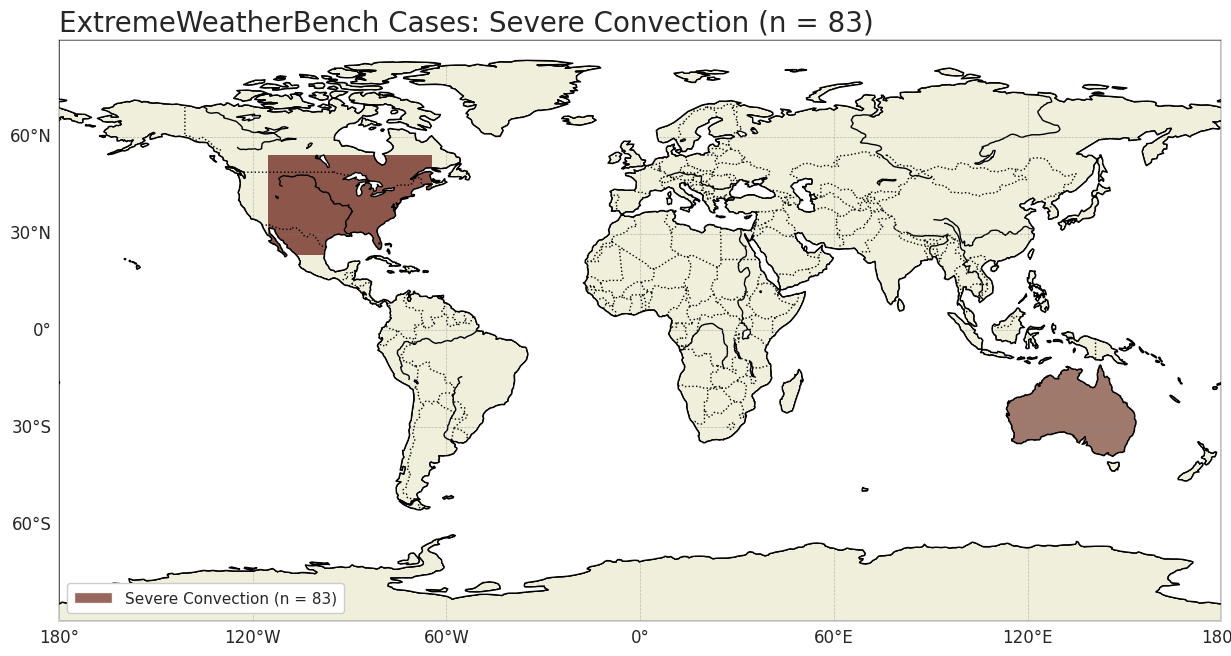

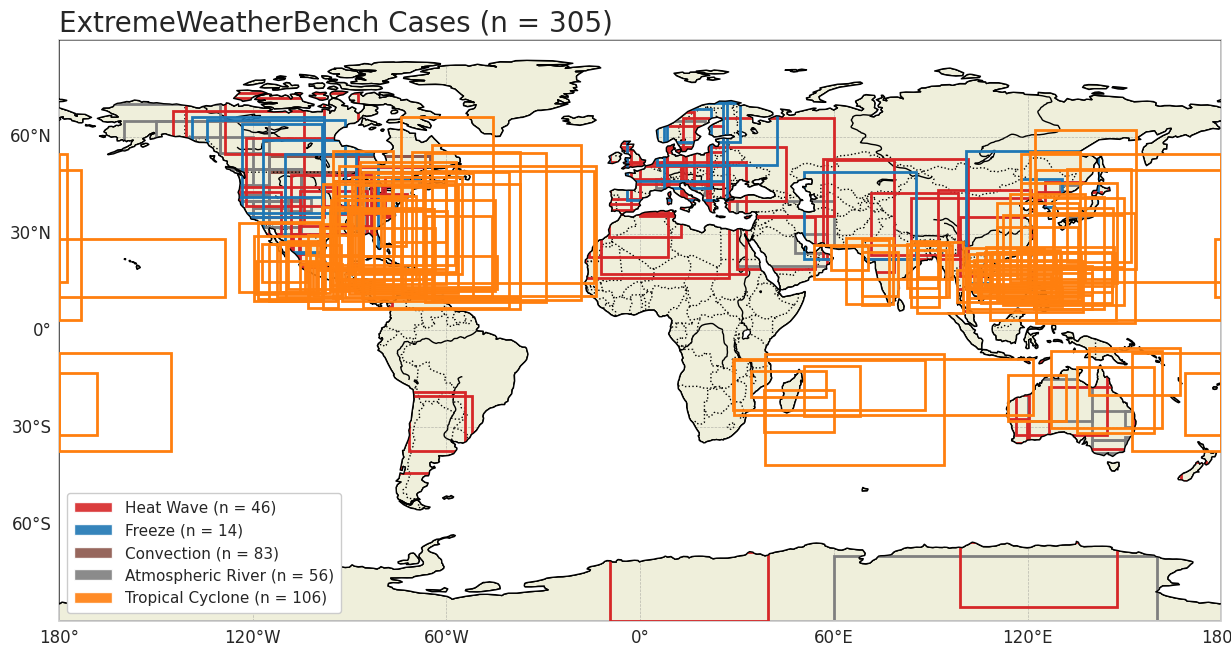

In [21]:
# plot the indivdual cases for each event type
plot_all_cases(ewb_cases, event_type='tropical_cyclone', filename=basepath + 'docs/notebooks/figs/ewb_tcs.png', fill_boxes=True)
plot_all_cases(ewb_cases, event_type='freeze', filename=basepath + 'docs/notebooks/figs/ewb_freeze.png', fill_boxes=True)
plot_all_cases(ewb_cases, event_type='heat_wave', filename=basepath + 'docs/notebooks/figs/ewb_heat.png', fill_boxes=True)
plot_all_cases(ewb_cases, event_type='atmospheric_river', filename=basepath + 'docs/notebooks/figs/ewb_ar.png', fill_boxes=True)
plot_all_cases(ewb_cases, event_type='severe_convection', filename=basepath + 'docs/notebooks/figs/ewb_convective.png', fill_boxes=True)

# plot all cases on one giant world map
plot_all_cases(ewb_cases, event_type=None, filename=basepath + 'docs/notebooks/figs/ewb_all.png', fill_boxes=False)

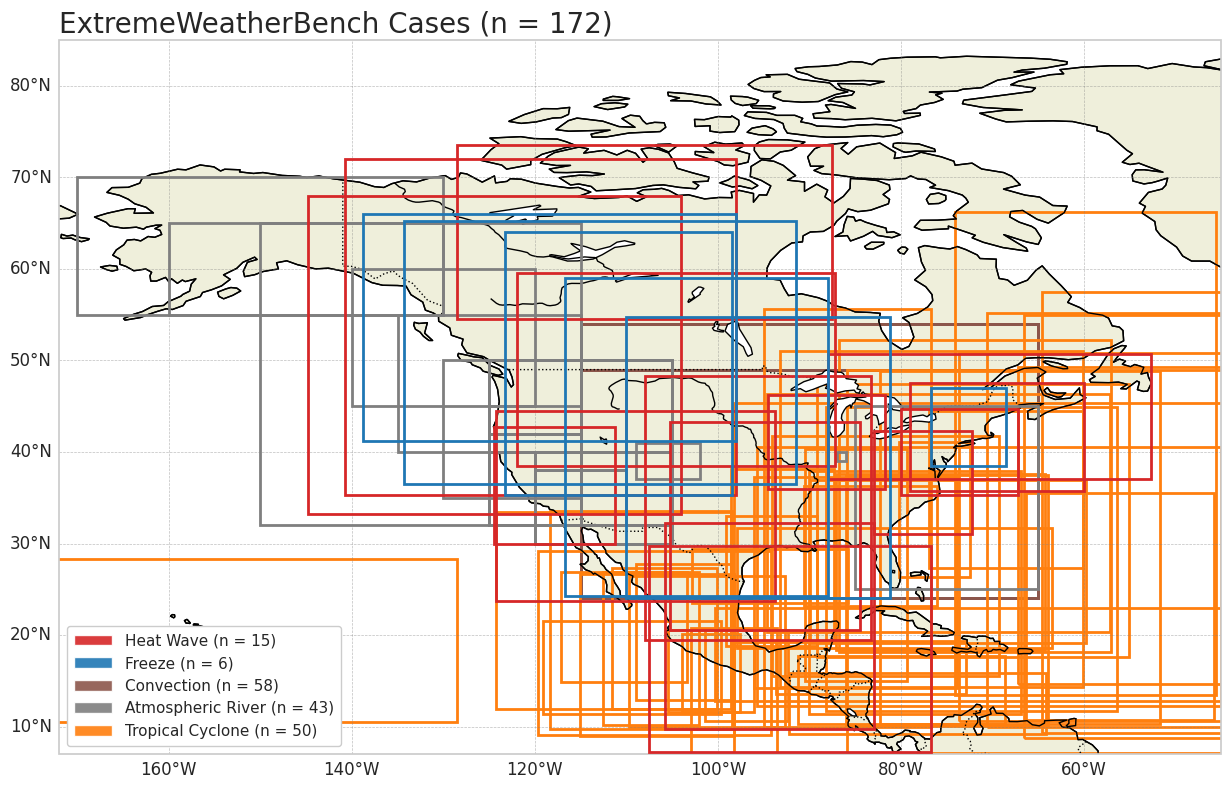

In [37]:
# plot North America
bot_lat = 7
top_lat = 85
left_lon = -172
right_lon = -45

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in North America'

plot_all_cases(ewb_cases, event_type=None, bounding_box=bounding_box, filename=basepath + 'docs/notebooks/figs/extreme_weather_cases_NA.png', fill_boxes=False)

20 -15 20 75


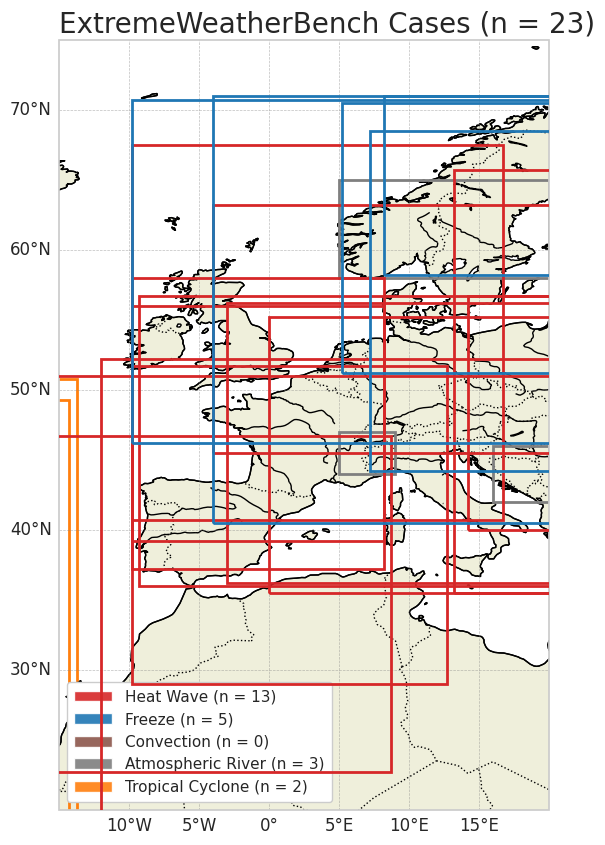

In [36]:
# plot Europe
bot_lat = 20
top_lat = 75
left_lon = -15
right_lon = 20

print(right_lon, left_lon, bot_lat, top_lat)

bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Europe'
plot_all_cases(ewb_cases, event_type=None, bounding_box=bounding_box, filename=basepath + 'docs/notebooks/figs/extreme_weather_cases_Europe.png', fill_boxes=False)


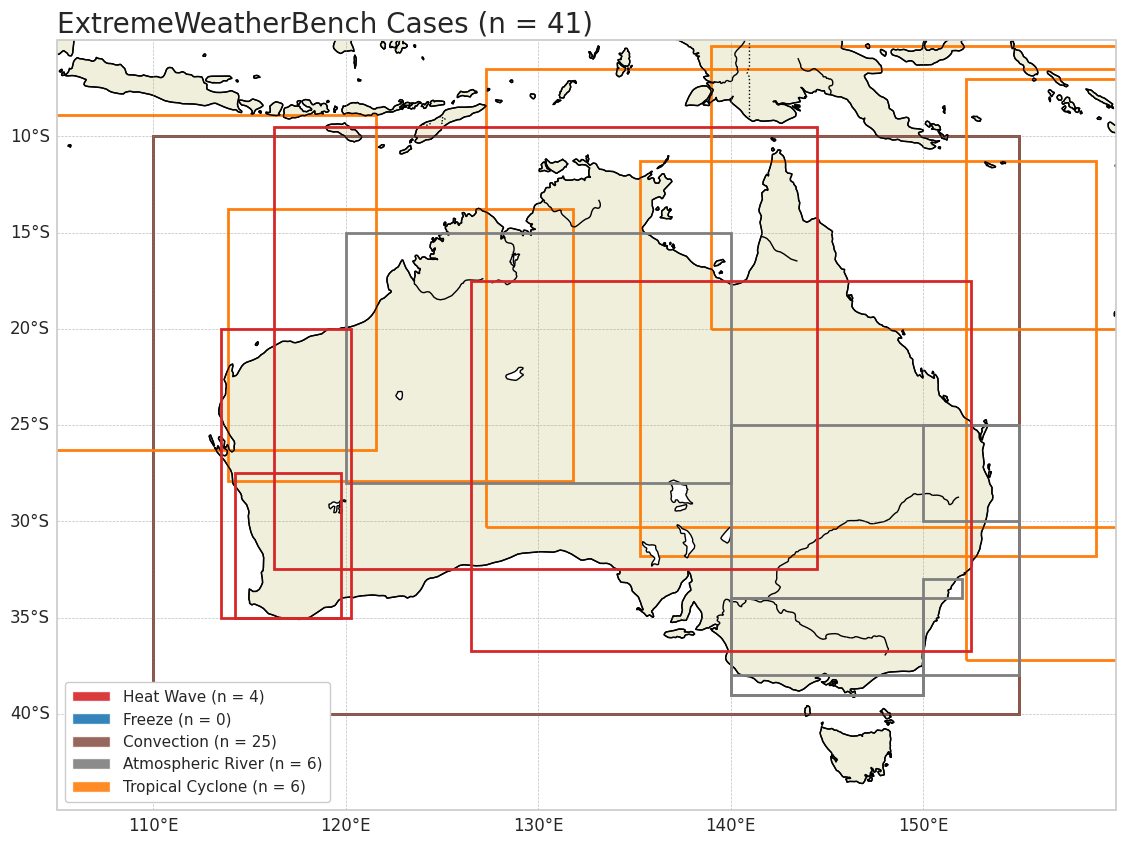

In [35]:
# plot Australia
bot_lat = -45
top_lat = -5
left_lon = 105
right_lon = 160
bounding_box = [left_lon, right_lon, bot_lat, top_lat]
plot_title = 'ExtremeWeatherBench Cases in Australia'

plot_all_cases(ewb_cases, event_type=None, bounding_box=bounding_box, filename=basepath + 'docs/notebooks/figs/extreme_weather_cases_Aus.png', fill_boxes=False)